# Moving mnist for validation of models - Vanilla convlstm

The problem we are trying to solve has note been done before, to ensure our models are working as expected we introduce the moving mnist to validate our models on a dataset that has shown to work well with this type of model.

Implementation based on 
https://towardsdatascience.com/video-prediction-using-convlstm-with-pytorch-lightning-27b195fd21a2

# Data loading

In [2]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import sys
sys.path.append('../')
import os
import errno
import numpy as np
import torch
import codecs
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from model.ConvLSTM import ConvLSTMCell
from model.models import VanillaConvLSTM
import torchvision.utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from datahelpers import *
from IPython.display import clear_output
from torchvision.utils import save_image, make_grid
import json

# Parameters

In [2]:
# Size of dim 0 of grid
n_steps_past = 10
n_steps_ahead = 1  # 4
NF=30
batch_size=6

# For saving
MODEL_NAME="Vanilla_conv_1_step_model"

# Data loader 

In [3]:
relative_path='data'

train_set = MovingMNIST(root=relative_path, train=True, download=False, max_norm=True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)


validation_set = MovingMNIST(root=relative_path, train=False, download=False, max_norm=True)

validation_loader = torch.utils.data.DataLoader(
                 dataset=validation_set,
                 batch_size=batch_size,
                 shuffle=True)

In [3]:
model = VanillaConvLSTM(nf=NF, in_chan=1)
CUDA=False
if torch.cuda.is_available():
    print("Cuda")
    CUDA=True
    model.cuda()

### Load a pretrained model

In [4]:
model.load_state_dict(torch.load('../state_dict/model_tranied_xxx',map_location=torch.device('cpu')))

<All keys matched successfully>

### Get model parameters

In [4]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

98791


In [5]:
# Print model parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([120, 31, 3, 3])
torch.Size([120])
torch.Size([120, 60, 3, 3])
torch.Size([120])
torch.Size([1, 30, 1, 3, 3])
torch.Size([1])


# Loss

In [6]:
criterion = nn.MSELoss()

# Optimizer

In [7]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Traning

### Verify model

In [8]:
# Reproduceabilitu
torch.manual_seed(3124)
np.random.seed(224)

In [9]:
for i, (inputs, target) in enumerate(train_loader):
    break

In [10]:
# Add channel and do forward pass
# B,T,C,H,W

# Asure that we get the correct number of timesteps
assert(model(inputs.unsqueeze(2), future_seq=n_steps_ahead, cuda=CUDA).shape[2]==n_steps_ahead)

### Helper functions 

For keeping track of learning and plotting predictions

Update code to be more efficient in argument passing

In [11]:
print("test")

test


In [12]:
def save_prediction(pred:torch.tensor, file_prefix:str = '', file_postfix:str = '', nrow=10):
    """
    Assumes tensor (b, t, c, h, w)
    """
    
    path = file_prefix
    if not file_prefix:
        path='moving_mnist_'
    for b in range(pred.shape[0]):
        torchvision.utils.save_image(make_grid(pred[b,:,:,:,:], padding=100, nrow=nrow), str(path)+ f'batchnr{b}'+str(file_postfix)+".png")
        
def plot_prediction(pred:torch.tensor,nrow=10):
    # Remove batch
    # b,t,c,w,h
    if len(pred.shape)>4:
        pred = [y for x in pred for y in x]
    plt.imshow(np.rot90(np.transpose(make_grid(pred,nrow=nrow).numpy())),origin='lower')
    plt.title("Prediction")
    
def plot_output_v_target(target, outputs, nrow=10):
    pred_eval = _join_out_ta(target, outputs)
    plot_prediction(pred_eval, nrow=nrow)
    
def save_output_v_target(target:torch.tensor, outputs:torch.tensor, nrow=10, file_prefix:str = '', file_postfix:str = ''):
    pred_eval = _join_out_ta(target, outputs)
    save_prediction(pred_eval, nrow=nrow, file_prefix=file_prefix, file_postfix=file_postfix)

def _join_out_ta(target, outputs):
    # Example
    # torch.cat((inputs.unsqueeze(2),model(inputs.unsqueeze(2), future_seq=10).permute(0,2,1,3,4)),dim=1)
    
    # assert same size except timesteps
    assert (target[:,0,:,:,:].shape==outputs[:,0,:,:,:].shape) and (len(target.shape)==5)
    return torch.cat((target, outputs), dim=1)

### Train model our dataset

In [13]:
for i, (inputs, targets) in enumerate(validation_loader):
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets
        if CUDA:
            y = y.cuda()
        break

In [14]:
y.device

device(type='cuda', index=0)

In [15]:
CUDA

True

In [17]:
SAVE_CHECKPOINTS=True

num_epochs = 30
itr = 0
# Save loss for plot
training_loss=[]
validation_loss=[]

t_L=train_loader

print("Start Iter")

# Status parameters
data_train_iter=75

global_steps =0
log_every=150

# Monitoring
t1=datetime.now()
t2=datetime.now()
for epoch in range(num_epochs):
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.eval()
    # For grid in validation set
    print("Starting validation")
    for i, (inputs, targets) in enumerate(validation_loader):
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets[:,0,:,:]
        if CUDA:
            y = y.cuda()

        # Forward pass to get output/logits
        y_hat = model.forward(x, future_seq=n_steps_ahead, cuda=CUDA).squeeze()
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y_hat, y)

        # Getting gradients w.r.t. parameters
        epoch_validation_loss += loss.cpu().detach().numpy()

    model.train()
    # For grid in traning set
    print("Starting Train")
    for i, (inputs,targets) in enumerate(train_loader):
        # Status updates
        if i%data_train_iter==0: 
            print(f"Done with {int(i*100/len(t_L))}% of train in epoch {epoch} \nSeconds since start: {(datetime.now()-t1).seconds} \nSeconds since last status: {(datetime.now()-t2).seconds}")
            t2=datetime.now()
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets[:,0,:,:]
        if CUDA:
            y = y.cuda()

        # Forward pass to get output/logits
        y_hat = model.forward(x, future_seq=n_steps_ahead,cuda=CUDA).squeeze()
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y_hat, y)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        
        # Status updates
        # Print loss every x steps after 1
        if (global_steps % log_every == 0) and len(validation_loss)>0:
            #Report status
            print(f'Epoch: {epoch}, Global steps: {global_steps}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            # Plot prediction
            plt.figure(figsize=(15,20))
            plt.subplot(2, 1, 1)
            plot_output_v_target(inputs.cpu().unsqueeze(2), y_hat.cpu().unsqueeze(1).unsqueeze(1).detach(), nrow=11)
            plt.subplot(2, 1, 2)
            _epoch = np.arange(len(training_loss))
            plt.plot(_epoch, training_loss, 'r', label='Training loss',)
            plt.plot(_epoch, validation_loss, 'b', label='Validation loss')
            plt.title("Traning and validation loos")
            plt.legend()
            plt.xlabel('Epoch'), plt.ylabel('VAL')
            plt.show()
            clear_output(wait=True)

            # Save pred
            try:
                save_output_v_target(inputs.cpu().unsqueeze(2), y_hat.cpu().unsqueeze(1).permute(0,2,1,3,4).detach(),nrow=10, file_prefix=f'./predictions/{type(model).__name__}_pred', file_postfix=epoch)
            except Exception as e:
                pass
                
        # Step taken
        global_steps+=1
        
    # Save
    if SAVE_CHECKPOINTS:
        model_name=f'./checkpoint_saves/{type(model).__name__}_{type(criterion).__name__}_checkpoint_{datetime.now()}'
        # Send dict to memory
        torch.save(model.state_dict(), model_name)
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_loader))
    validation_loss.append(epoch_validation_loss/len(validation_loader))

Done with 95% of train in epoch 29 
Seconds since start: 3266 
Seconds since last status: 5


### Loss evaluation

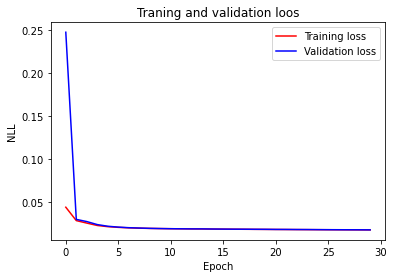

In [18]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.title("Traning and validation loos")
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

### Saving stats

In [19]:
if True:
    train_eval={'validation_loss':validation_loss,
     'traning_loss':training_loss
    }
    file_name=f'{type(model).__name__}_{type(criterion).__name__}_train_eval_stats_{datetime.now()}.json'
    with open(file_name, 'w') as outfile:
        json.dump(train_eval, outfile)
    with open(file_name) as json_file:
        data = json.load(json_file)

## Saving the model

In [ ]:
model_name=f'model_tranied_'+str(type(criterion).__name__)+'_'+MODEL_NAME+'_finish_{datetime.now()}'
torch.save(model.state_dict(), model_name)